# Apartat C

## Setup

* Importem les llibreries
* Configurem pandas
* Importem el dataset
* Inspeccionem les dimensions de les dades

In [48]:
## APARTADO C

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualitzarem 4 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.4f' % x)

dataset = pd.read_csv("Consumo_cerveja.txt", header=0, delimiter=',', decimal=".", names=["DATA","TEMPMED","TEMPMIN","TEMPMAX","PREC","FINSEM","CONSUM"])

data = dataset.values

x = data[:, 1:-1]
y = data[:, -1]

print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)


Dimensionalitat de la BBDD: (365, 7)
Dimensionalitat de les entrades X (365, 5)
Dimensionalitat de l'atribut Y (365,)


## Mostrem les característiques del dataset

* Número d'entrades
* Descripció de les columnes
    * Nom de cada columna
    * Quantitat de registres amb valor
    * Si pot ser null o no
    * Tipus de dada

La part del tipus de dada es especialment important. Si les dades no s'importen com a números no podrem treballar correctament amb el dataset.

In [49]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATA     365 non-null    object 
 1   TEMPMED  365 non-null    float64
 2   TEMPMIN  365 non-null    float64
 3   TEMPMAX  365 non-null    float64
 4   PREC     365 non-null    float64
 5   FINSEM   365 non-null    int64  
 6   CONSUM   365 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 20.1+ KB


## Busquem valors nulls

No n'hi ha cap.

In [50]:
print("Per comptar el nombre de valors no existents:")
print(dataset.isnull().sum())

Per comptar el nombre de valors no existents:
DATA       0
TEMPMED    0
TEMPMIN    0
TEMPMAX    0
PREC       0
FINSEM     0
CONSUM     0
dtype: int64


## Visualitzem els primers registres

In [51]:
print("Per visualitzar les primeres 5 mostres de la BBDD:")
dataset.head()

Per visualitzar les primeres 5 mostres de la BBDD:


,DATA,TEMPMED,TEMPMIN,TEMPMAX,PREC,FINSEM,CONSUM
0,2015-01-01,27.3000,23.9000,32.5000,0.0000,0,25461
1,2015-01-02,27.0200,24.5000,33.5000,0.0000,0,28972
2,2015-01-03,24.8200,22.4000,29.9000,0.0000,1,30814
3,2015-01-04,23.9800,21.5000,28.6000,1.2000,1,29799
4,2015-01-05,23.8200,21.0000,28.3000,0.0000,0,28900


In [52]:
print("Per veure estadístiques dels atributs numèrics de la BBDD:")
dataset.describe()

Per veure estadístiques dels atributs numèrics de la BBDD:


,TEMPMED,TEMPMIN,TEMPMAX,PREC,FINSEM,CONSUM
count,365.0000,365.0000,365.0000,365.0000,365.0000,365.0000
mean,21.2264,17.4614,26.6115,5.1967,0.2849,25401.3671
std,3.1801,2.8262,4.3174,12.4178,0.4520,4399.1427
min,12.9000,10.6000,14.5000,0.0000,0.0000,14343.0000
25%,19.0200,15.3000,23.8000,0.0000,0.0000,22008.0000
50%,21.3800,17.9000,26.9000,0.0000,0.0000,24867.0000
75%,23.2800,19.6000,29.4000,3.2000,1.0000,28631.0000
max,28.8600,24.5000,36.5000,94.8000,1.0000,37937.0000


## Mostrem correlacions

Mostrem les correlacions entre els atributs numerics.

El que ens importa especialment son les correlacions entre l'atribut de consum i la resta d'atributs.

Utilitzem el seguent criteri per les correlacions segons el seu valor absolut:
* \[0, 0.3) -> sense correlacio
* \[0.3, 0.5) -> correlacio baixa
* \[0.5, 0.7) -> correlacio mitja
* \[0.7, 0.9) -> correlacio alta
* \[0.9, 1\] -> correlacio molt alta

Veiem les seguents correlacions:
* Consum i temperatura mitjana: correlacio mitja
* Consum i temperatura minima: correlacio baixa
* Consum i temperatura maxima: correlacio mitja
* Consum i precipitacio: sense correlacio
* Consum i cap de setmana: correlacio mitja
      
No hi ha cap variable que tingui correlacio alta o molt alta amb el consum.
    

També hi ha correlacions mitjes o altes entre les diferents mostres de temperatures (minima, mitjana, maxima).

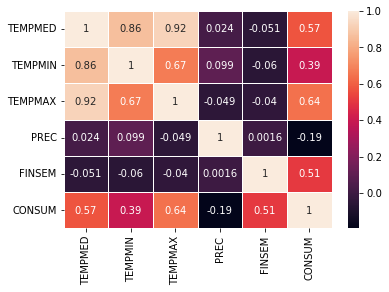

In [53]:
co = dataset.corr()
plt.figure()

ax = sns.heatmap(co, annot=True, linewidths=.5)

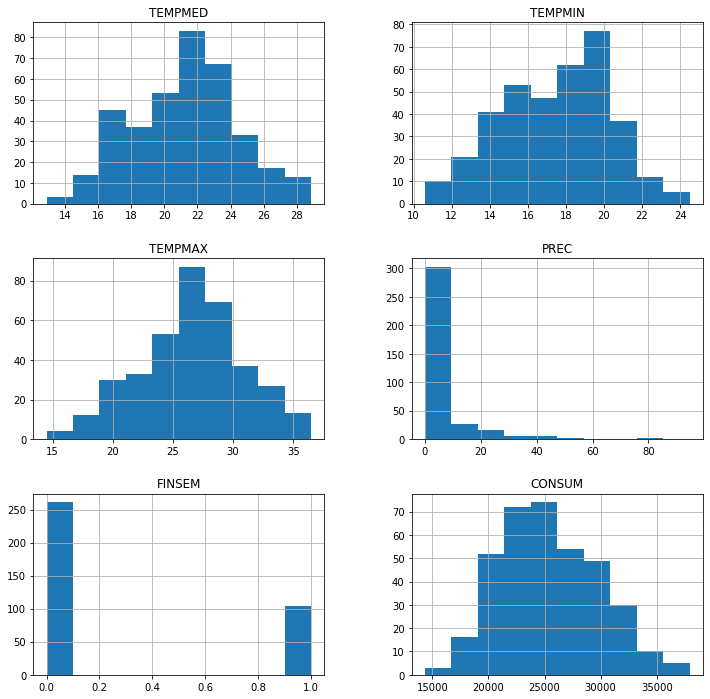

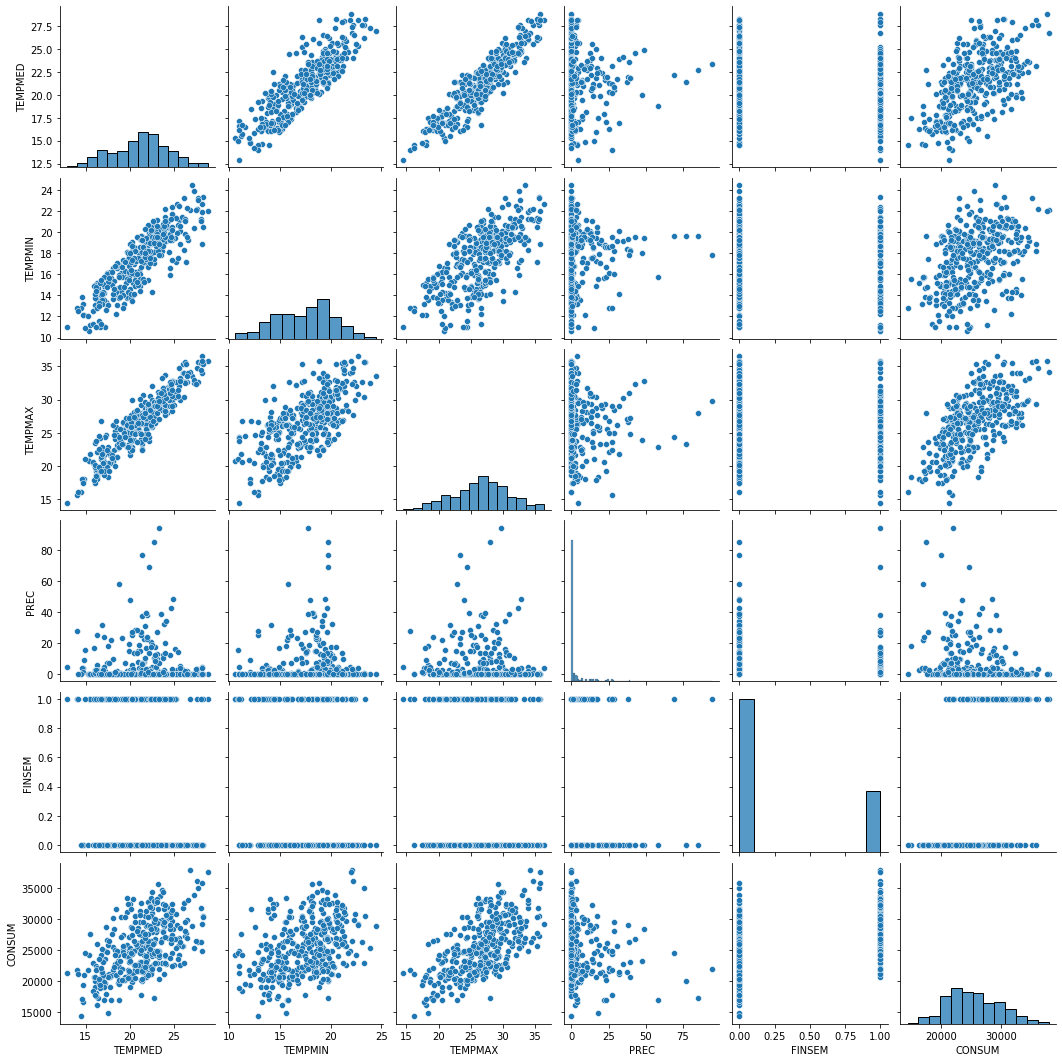

In [54]:
dataset.hist(figsize=(12, 12))
rel = sns.pairplot(dataset)

## Descartem atributs

Com que les precipitacions no tenen correlacio amb el consum, i tampoc segueixen una distribució Gaussiana, el descartem.
Com que la temperatura mínima te correlació baixa, la descartem també.
I com hem descartat alguns valors, actualitzem els valors a x.

In [55]:
dataset2 = dataset.drop(['PREC'], axis=1)

data = dataset2.values
x = data[:, 1:-1]
y = data[:, -1]

# Apartat B

In [56]:
## APARTADO B

import math
import numpy as np #importem la llibreria
np.warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.model_selection import train_test_split

def mse(v1, v2):
    return ((v1 - v2)**2).mean()

def linearReg(x, y):
    # Creem un objecte de regressió de sklearn
    #regr = LinearRegression()
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

def lassoReg(x, y):
    # Creem un objecte de regressió de sklearn
    #regr = LinearRegression()
    regr = Lasso()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

def ridgeReg(x, y):
    # Creem un objecte de regressió de sklearn
    #regr = LinearRegression()
    regr = Ridge()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

def elasticReg(x, y):
    # Creem un objecte de regressió de sklearn
    #regr = LinearRegression()
    regr = ElasticNet()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr


In [57]:
def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t

x = x.astype(float)

x = standarize(x)


In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

from sklearn.metrics import r2_score

regr = linearReg(x_train, y_train)
error = mse(y_test, regr.predict(x_test)) # calculem error
r2 = r2_score(y_test, regr.predict(x_test))
print("Linear Regression:")
print("Error en atribut: %f" %( error))
print("R2 score en atribut: %f" %( r2))

regr = lassoReg(x_train, y_train)
error = mse(y_test, regr.predict(x_test)) # calculem error
r2 = r2_score(y_test, regr.predict(x_test))
print("Lasso:")
print("Error en atribut: %f" %( error))
print("R2 score en atribut: %f" %( r2))

regr = ridgeReg(x_train, y_train)
error = mse(y_test, regr.predict(x_test)) # calculem error
r2 = r2_score(y_test, regr.predict(x_test))
print("Ridge:")
print("Error en atribut: %f" %( error))
print("R2 score en atribut: %f" %( r2))

regr = elasticReg(x_train, y_train)
error = mse(y_test, regr.predict(x_test)) # calculem error
r2 = r2_score(y_test, regr.predict(x_test))
print("ElasticNet:")
print("Error en atribut: %f" %( error))
print("R2 score en atribut: %f" %( r2))

Linear Regression:
Error en atribut: 5742944.011226
R2 score en atribut: 0.729744
Lasso:
Error en atribut: 5738621.632752
R2 score en atribut: 0.729948
Ridge:
Error en atribut: 5761669.957373
R2 score en atribut: 0.728863
ElasticNet:
Error en atribut: 7435545.582289
R2 score en atribut: 0.650093


In [59]:
# APARTADO A

class Regressor(object):
    def __init__(self, w0, w1, alpha):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        self.w0 = w0
        self.w1 = w1
        self.alpha = alpha

        
    def predict(self, x):
        # implementar aqui la funció de prediccio
        pass
    
    def __update(self, hy, y):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        pass
    
    def train(self, max_iter, epsilon):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        pass